In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import os

2025-03-18 08:47:31.354225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 08:47:31.354889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 08:47:31.357949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 08:47:31.367283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742258851.383215    8048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742258851.38

In [49]:
# Load dataset
files = ['./dataset/MA-A.xlsx', './dataset/NORTHBOUND.xlsx', './dataset/SOUTHBOUND.xlsx']
sheets = ["2018", "2019", "2020", "2021", "2022", "2023"]

def load_and_preprocess_data(files, sheets):
    df_list = []
    for file in files:
        if os.path.exists(file):
            for sheet in sheets:
                try:
                    temp_df = pd.read_excel(file, sheet_name=sheet)

                    # Data cleaning
                    if 'TRAFFIC STATUS' in temp_df.columns:
                        temp_df.drop(columns=['TRAFFIC STATUS'], inplace=True)

                    temp_df['TIME(24 HOUR)'] = temp_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
                    temp_df['Datetime'] = pd.to_datetime(
                        temp_df['DATE'].astype(str) + ' ' + temp_df['TIME(24 HOUR)'],
                        dayfirst=True, errors='coerce'
                    )
                    temp_df = temp_df.dropna(subset=['Datetime']).sort_values('Datetime')

                    # Extract time features
                    temp_df['Hour'] = temp_df['Datetime'].dt.hour
                    temp_df['DayOfWeek'] = temp_df['Datetime'].dt.dayofweek
                    temp_df['Month'] = temp_df['Datetime'].dt.month

                    df_list.append(temp_df)
                except Exception as e:
                    print(f"Error loading {file} - {sheet}: {e}")

    return pd.concat(df_list, ignore_index=True) if df_list else None

df = load_and_preprocess_data(files, sheets)

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY'], drop_first=True)

df.head()

,DATE,TIME(24 HOUR),ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,DAY OF THE WEEK_Monday,...,DAY OF THE WEEK_Thursday,DAY OF THE WEEK_Tuesday,DAY OF THE WEEK_Wednesday,WEATHER_Overcast,WEATHER_Passing Clouds,WEATHER_Rainy,WEATHER_Sunny,WEATHER_Thunderstorm,ROAD CONDITION_Wet,HOLIDAY_YES
0,01/01/2018,00:00:00,0,36,224,2018-01-01 00:00:00,0,0,1,True,...,False,False,False,False,True,False,False,False,False,True
1,01/01/2018,01:00:00,0,27,171,2018-01-01 01:00:00,1,0,1,True,...,False,False,False,False,True,False,False,False,False,True
2,01/01/2018,02:00:00,0,24,119,2018-01-01 02:00:00,2,0,1,True,...,False,False,False,False,True,False,False,False,False,True
3,01/01/2018,03:00:00,0,22,173,2018-01-01 03:00:00,3,0,1,True,...,False,False,False,False,True,False,False,False,False,True
4,01/01/2018,04:00:00,0,38,168,2018-01-01 04:00:00,4,0,1,True,...,False,False,False,False,True,False,False,False,False,True


In [50]:
target_column = 'TRAFFIC VOLUME'
features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
target = df[target_column]

# Scale input and output
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten()

# joblib.dump(scaler_X, "scaler_X.pkl")
# joblib.dump(scaler_y, "scaler_y.pkl")

X_scaled.shape, y_scaled.shape

df.head()

,DATE,TIME(24 HOUR),ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,DAY OF THE WEEK_Monday,...,DAY OF THE WEEK_Thursday,DAY OF THE WEEK_Tuesday,DAY OF THE WEEK_Wednesday,WEATHER_Overcast,WEATHER_Passing Clouds,WEATHER_Rainy,WEATHER_Sunny,WEATHER_Thunderstorm,ROAD CONDITION_Wet,HOLIDAY_YES
0,01/01/2018,00:00:00,0,36,224,2018-01-01 00:00:00,0,0,1,True,...,False,False,False,False,True,False,False,False,False,True
1,01/01/2018,01:00:00,0,27,171,2018-01-01 01:00:00,1,0,1,True,...,False,False,False,False,True,False,False,False,False,True
2,01/01/2018,02:00:00,0,24,119,2018-01-01 02:00:00,2,0,1,True,...,False,False,False,False,True,False,False,False,False,True
3,01/01/2018,03:00:00,0,22,173,2018-01-01 03:00:00,3,0,1,True,...,False,False,False,False,True,False,False,False,False,True
4,01/01/2018,04:00:00,0,38,168,2018-01-01 04:00:00,4,0,1,True,...,False,False,False,False,True,False,False,False,False,True


In [51]:
def create_sequences(data, targets, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size : i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

window_size = 24
forecast_horizon = 24

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size, forecast_horizon)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

X_train.shape, y_train.shape

((49728, 24, 18), (49728, 24))

In [52]:
print("Training Features:", list(df.columns))

Training Features: ['DATE', 'TIME(24 HOUR)', 'ACCIDENTS', 'AVERAGE SPEED', 'TRAFFIC VOLUME', 'Datetime', 'Hour', 'DayOfWeek', 'Month', 'DAY OF THE WEEK_Monday', 'DAY OF THE WEEK_Saturday', 'DAY OF THE WEEK_Sunday', 'DAY OF THE WEEK_Thursday', 'DAY OF THE WEEK_Tuesday', 'DAY OF THE WEEK_Wednesday', 'WEATHER_Overcast', 'WEATHER_Passing Clouds', 'WEATHER_Rainy', 'WEATHER_Sunny', 'WEATHER_Thunderstorm', 'ROAD CONDITION_Wet', 'HOLIDAY_YES']


In [54]:
# Encoder
encoder_inputs = Input(shape=(window_size, X_train.shape[2]))
encoder_lstm = LSTM(128, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoders
decoder_inputs = RepeatVector(forecast_horizon)(encoder_outputs)
decoder_lstm = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Output Layer
output_layer = TimeDistributed(Dense(1, activation="linear"))(decoder_outputs)

# Compile Model
model = Model(inputs=encoder_inputs, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Save Model
# model.save("traffic_forecasting_seq2seq.h5")

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0238 - mae: 0.1099 - val_loss: 0.0075 - val_mae: 0.0657
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.0125 - mae: 0.0763 - val_loss: 0.0175 - val_mae: 0.1003
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0102 - mae: 0.0675 - val_loss: 0.0122 - val_mae: 0.0829
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0089 - mae: 0.0623 - val_loss: 0.0180 - val_mae: 0.1011
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0084 - mae: 0.0598 - val_loss: 0.0128 - val_mae: 0.0832
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0077 - mae: 0.0570 - val_loss: 0.0078 - val_mae: 0.0640
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0072 - mae: 0.0550 - val_loss: 0.0116 - val_mae: 0.0754
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0068 - mae: 0.0531 - val_loss: 0.0103 - val_mae: 0.0697
Epoch 9/100
622/622 ━━━━━━━━━━━━

In [55]:
# Compute evaluation metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

# Print metrics
print("\nPerformance on Testing Dataset:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Performance on Testing Dataset:
MAE: 388.0790
MSE: 331679.7077
RMSE: 575.9164
R2 Score: 0.7569


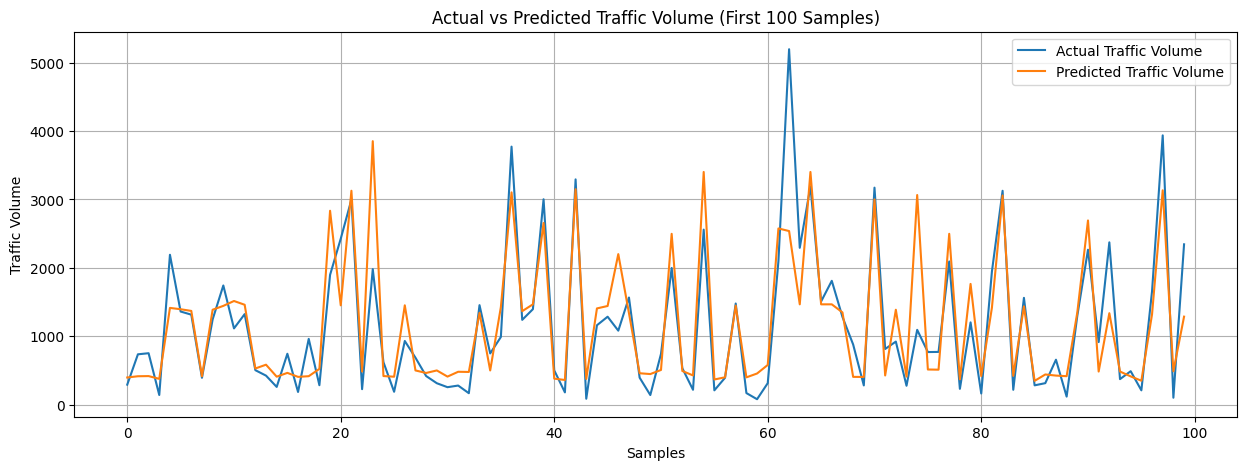

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[:100], label="Actual Traffic Volume")
plt.plot(y_pred[:100], label="Predicted Traffic Volume")
plt.title("Actual vs Predicted Traffic Volume (First 100 Samples)")
plt.xlabel("Samples")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid()
plt.show()

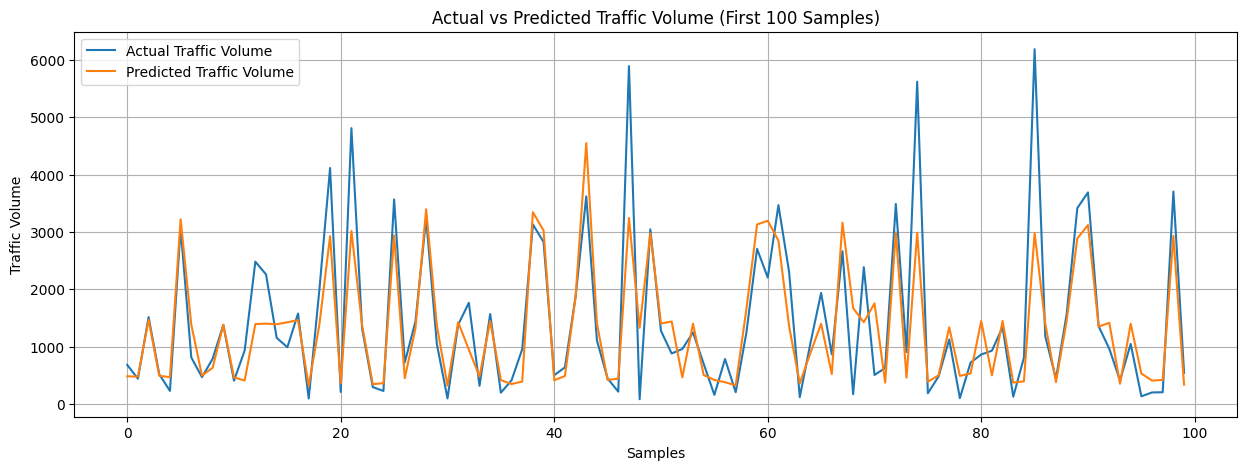

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[-100:], label="Actual Traffic Volume")
plt.plot(y_pred[-100:], label="Predicted Traffic Volume")
plt.title("Actual vs Predicted Traffic Volume (First 100 Samples)")
plt.xlabel("Samples")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

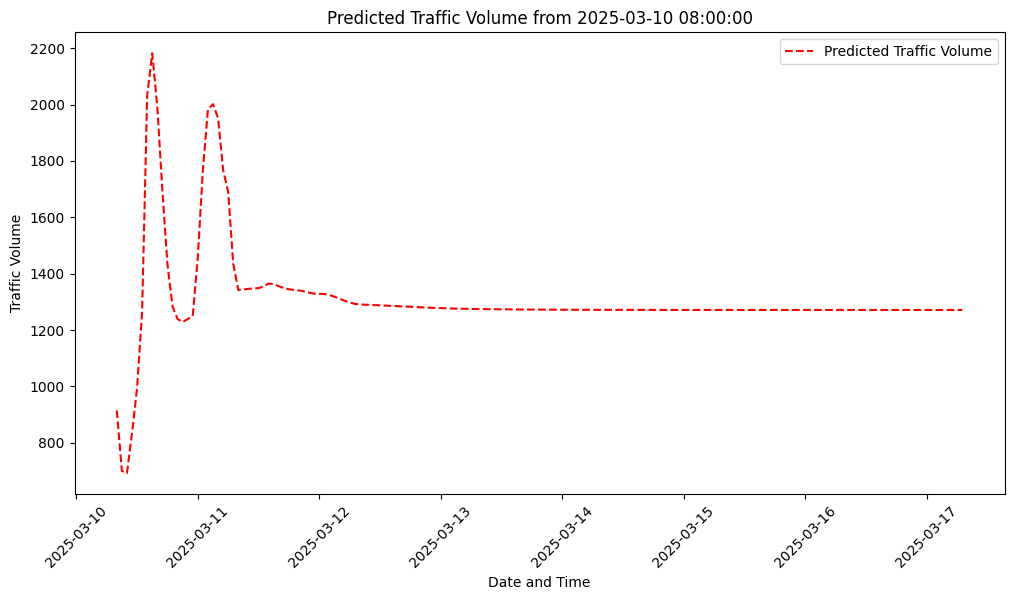

,Datetime,Predicted Traffic Volume
0,2025-03-10 08:00:00,914.454346
1,2025-03-10 09:00:00,699.509583
2,2025-03-10 10:00:00,691.321838
3,2025-03-10 11:00:00,833.184937
4,2025-03-10 12:00:00,992.284851


In [63]:
def forecast_traffic(initial_input, model, scaler_X, scaler_y, forecast_steps, start_datetime):
    """
    Predicts traffic volume dynamically from a user-defined start date and time.

    Parameters:
    - initial_input: The last known window of traffic data (shape: (1, window_size, features))
    - model: Trained LSTM Seq2Seq model
    - scaler_X: Scaler for input features
    - scaler_y: Scaler for target traffic volume
    - forecast_steps: Number of future time steps to predict
    - start_datetime: User-defined start datetime for forecasting

    Returns:
    - future_df: DataFrame containing predicted traffic volume with corresponding timestamps
    """

    current_input = initial_input.copy()
    future_predictions = []
    future_dates = []

    # Start from the user-defined date and time
    current_datetime = pd.to_datetime(start_datetime)

    for _ in range(forecast_steps):
        # Predict the next time step
        pred_scaled = model.predict(current_input)

        # Inverse transform to get actual traffic volume
        pred_actual = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
        
        # Store the prediction
        future_predictions.append(pred_actual[0])  # Assuming single output per step
        
        # Store the corresponding date
        future_dates.append(current_datetime)

        # Increment the datetime by 1 hour
        current_datetime += pd.Timedelta(hours=1)

        # Create a placeholder for new input with same feature shape
        new_input = np.zeros_like(current_input)  # Shape: (1, window_size, num_features)

        # Shift the input window
        new_input[:, :-1, :] = current_input[:, 1:, :]

        # Replace only the traffic volume feature with predicted value
        new_input[:, -1, 0] = pred_scaled[0, 0]  # Assuming traffic volume is at index 0

        current_input = new_input

    # Create a DataFrame for visualization and analysis
    future_df = pd.DataFrame({
        "Datetime": future_dates,
        "Predicted Traffic Volume": future_predictions
    })

    return future_df

# Example usage:
forecast_steps = 24 * 7  # Predict next 7 days (168 hours)
initial_input = X_test[-1:].copy()  # Start with the last test sample

# User-defined start date and time
user_input_datetime = "2025-03-10 08:00:00"  # Example: March 10, 2025 at 08:00 AM

predicted_df = forecast_traffic(initial_input, model, scaler_X, scaler_y, forecast_steps, user_input_datetime)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(predicted_df["Datetime"], predicted_df["Predicted Traffic Volume"], label="Predicted Traffic Volume", color='red', linestyle='dashed')
plt.xlabel("Date and Time")
plt.ylabel("Traffic Volume")
plt.title(f"Predicted Traffic Volume from {user_input_datetime}")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Display the first few predictions
predicted_df.head()

In [5]:
# Load new dataset
new_data_file = './dataset/TESTING_DATASET.xlsx'
new_df = pd.read_excel(new_data_file)
if 'TRAFFIC STATUS' in new_df.columns:
    new_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
new_df['ROAD CONDITION'] = new_df['ROAD CONDITION'].str.capitalize()
new_df['TIME(24 HOUR)'] = new_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
new_df['Datetime'] = pd.to_datetime(new_df['DATE'].astype(str) + ' ' + new_df['TIME(24 HOUR)'], dayfirst=True, errors='coerce')
new_df = new_df.dropna(subset=['Datetime']).sort_values('Datetime')
new_df['Hour'] = new_df['Datetime'].dt.hour
new_df['DayOfWeek'] = new_df['Datetime'].dt.dayofweek
new_df['Month'] = new_df['Datetime'].dt.month

new_df.head()

NameError: name 'pd' is not defined

In [26]:
# Preprocess new data
window_size = 24
X_new, y_actual_new = preprocess_new_data(new_df, scaler_X, window_size)

new_df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,HourCos,DaySin,DayCos,MonthSin,MonthCos
0,01/01/2016,00:00:00,Friday,Clear,Dry,YES,0,39,342,2016-01-01 00:00:00,0,4,1,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025
1,01/01/2016,01:00:00,Friday,Clear,Dry,YES,0,29,232,2016-01-01 01:00:00,1,4,1,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025
2,01/01/2016,02:00:00,Friday,Clear,Dry,YES,0,39,200,2016-01-01 02:00:00,2,4,1,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025
3,01/01/2016,03:00:00,Friday,Clear,Dry,YES,0,31,183,2016-01-01 03:00:00,3,4,1,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025
4,01/01/2016,04:00:00,Friday,Clear,Dry,YES,0,38,222,2016-01-01 04:00:00,4,4,1,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025


In [27]:
print("Testing Features:", list(new_df.columns))
print(list(features));

Testing Features: ['DATE', 'TIME(24 HOUR)', 'DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY', 'ACCIDENTS', 'AVERAGE SPEED', 'TRAFFIC VOLUME', 'Datetime', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos']
['ACCIDENTS', 'AVERAGE SPEED', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos', 'DAY OF THE WEEK_Monday', 'DAY OF THE WEEK_Saturday', 'DAY OF THE WEEK_Sunday', 'DAY OF THE WEEK_Thursday', 'DAY OF THE WEEK_Tuesday', 'DAY OF THE WEEK_Wednesday', 'WEATHER_Overcast', 'WEATHER_Passing Clouds', 'WEATHER_Rainy', 'WEATHER_Sunny', 'WEATHER_Thunderstorm', 'ROAD CONDITION_Wet', 'HOLIDAY_YES']


In [28]:
# Ensure model is in memory
if 'model' not in globals():
    raise ValueError("Trained model not found. Ensure you have trained the model in a previous cell.")

In [29]:
# Make predictions
y_pred_scaled_new = model.predict(X_new).flatten()
y_pred_new = scaler_y.inverse_transform(y_pred_scaled_new.reshape(-1, 1)).flatten()

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


In [30]:
# Compute metrics
if y_actual_new is not None:
    mae_new = mean_absolute_error(y_actual_new, y_pred_new)
    mse_new = mean_squared_error(y_actual_new, y_pred_new)
    rmse_new = np.sqrt(mean_squared_error(y_actual_new, y_pred_new))
    r2_new = r2_score(y_actual_new, y_pred_new)

    print("\nPerformance on Testing:")
    print(f"MAE: {mae_new:.4f}")
    print(f"MSE: {mse_new:.4f}")
    print(f"RMSE: {rmse_new:.4f}")
    print(f"R2 Score: {r2_new:.4f}")
else:
    print("\nNo actual traffic volume data available for evaluation.")


Performance on Testing:
MAE: 229.8403
MSE: 98119.1641
RMSE: 313.2398
R2 Score: 0.6593


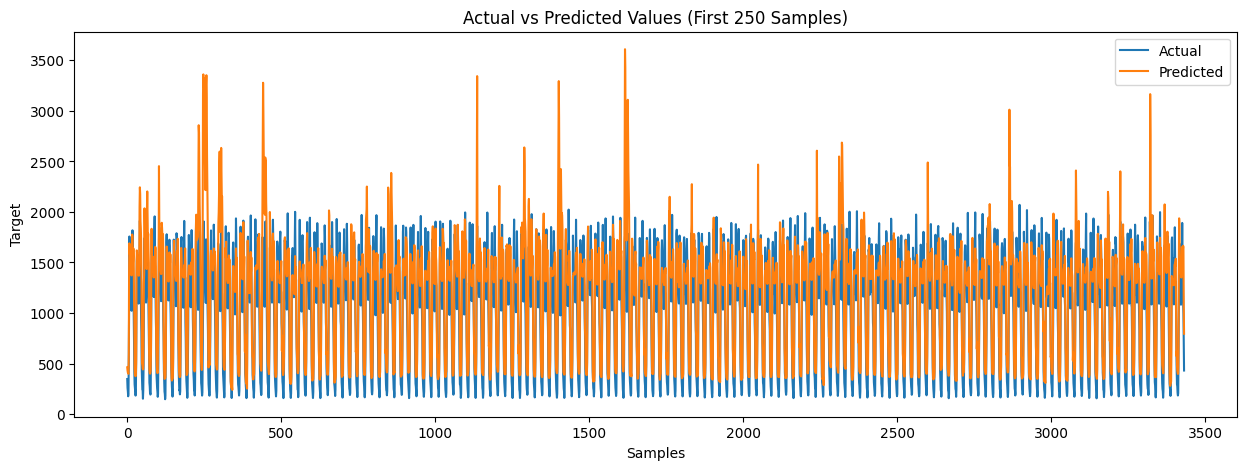

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new, label="Actual")
plt.plot(y_pred_new, label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

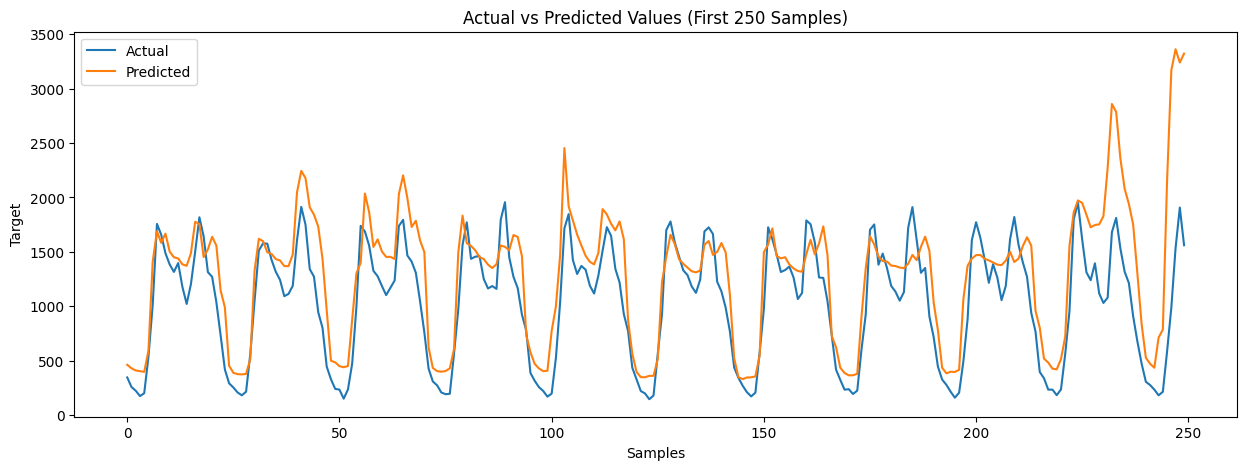

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[:250], label="Actual")
plt.plot(y_pred_new[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

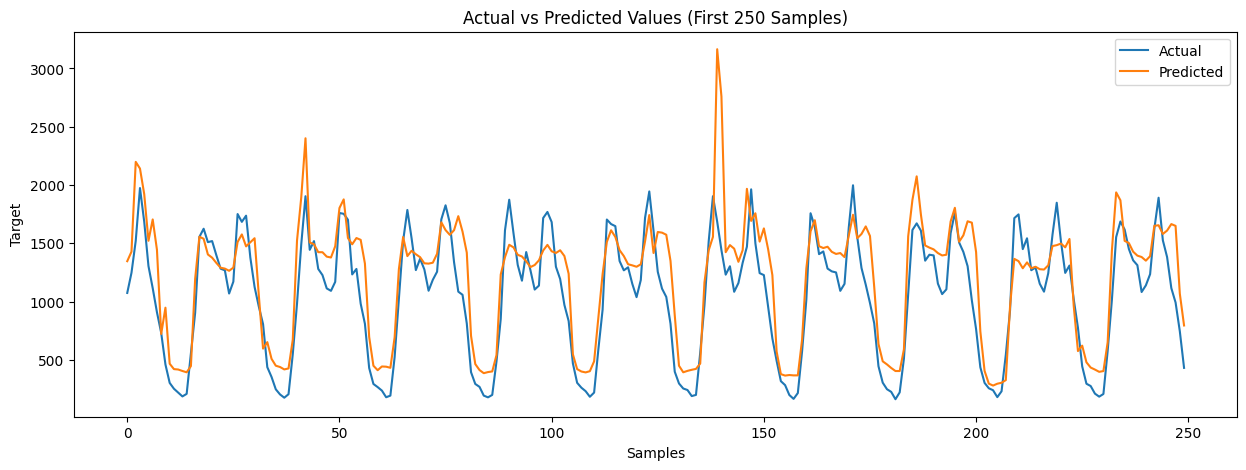

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[-250:], label="Actual")
plt.plot(y_pred_new[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [34]:
# Save the model
model.save("traffic_forecasting.h5")

In [35]:
# Save the scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

In [49]:
joblib.dump(list(features.columns), "feature_names.pkl")

['feature_names.pkl']